# Imports

In [169]:
import pandas             as pd
import numpy              as np
import seaborn            as sns
import inflection
import math
import datetime
import matplotlib
import matplotlib.pyplot  as plt
import matplotlib.ticker  as mticker

from IPython.core.display import HTML
from IPython.display      import Image
from matplotlib.ticker    import StrMethodFormatter
from tabulate             import tabulate
from scipy                import stats      as ss

## Helper Functions

In [172]:
def personal_settings():
    
    # plotly settings
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [20, 10]
    plt.rcParams['font.size'] = 24
        
    # notebook settings
    display(HTML('<style>.container{width:90% !important;}</style>'))
    np.set_printoptions(suppress=True)
    pd.set_option('display.float_format', '{:.2f}'.format)

    # seaborn settings
    sns.set(rc={'figure.figsize':(15,6)})
    sns.set_theme(style = 'darkgrid', font_scale = 1.5)
    
def season_from_date(date):
    year = str(date.year)
    seasons = {'spring': pd.date_range(start='01/03/'+year, end='31/05/'+year),
               'summer': pd.date_range(start='01/06/'+year, end='30/09/'+year),
               'autumn': pd.date_range(start='01/09/'+year, end='30/11/'+year)}
    if date in seasons['spring']:
        return 'spring'
    if date in seasons['summer']:
        return 'summer'
    if date in seasons['autumn']:
        return 'autumn'
    else:
        return 'winter'
    
def cramer_v(x,y):
    cm = pd.crosstab(x,y).to_numpy() # contingency matriz
    chi2 = ss.chi2_contingency(cm)[0]
    n = cm.sum()
    r, k = cm.shape
    
    # bias correction
    chi2_tilda = max (0, chi2 - (k-1)*(r-1)/(n-1))
    k_tilda = k - (k-1)**2/(n-1);
    r_tilda = r - (r-1)**2/(n-1);
    
    return np.sqrt( (chi2_tilda/n) / (min (k_tilda-1, r_tilda-1)) )

In [51]:
personal_settings();

## Loading Data

In [52]:
df_sales_raw = pd.read_csv('../data/raw/train.csv', low_memory=False)
df_store_raw = pd.read_csv('../data/raw/store.csv', low_memory=False)

# merging datsets
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

# DATA DESCRIPTION

In [117]:
df1=df_raw.copy()

## Rename Columns

In [118]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [119]:
cols_old=['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
           'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
           'CompetitionDistance', 'CompetitionOpenSinceMonth',
           'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
           'Promo2SinceYear', 'PromoInterval']


# changing the name of the columns
snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase, cols_old))

# renaming dataset columns
df1.columns = cols_new
df1.rename(columns={'promo_interval': 'promo2_interval'}, inplace=True)
print(df1.columns)

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo2_interval'],
      dtype='object')


## Data Dimension

In [120]:
print('Number of rows: {:,}' .format(df1.shape[0]))
print('Number of columns: {:,}' .format(df1.shape[1]))

Number of rows: 1,017,209
Number of columns: 18


## Data Types

In [121]:
print(df1.dtypes)
df1.head(2)

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo2_interval                  object
dtype: object


,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo2_interval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.00,9.00,2008.00,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.00,11.00,2007.00,1,13.00,2010.00,"Jan,Apr,Jul,Oct"


## Check NA 

In [122]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo2_interval                 508031
dtype: int64

## Filling Out NA

In [123]:
# analysing attributes with NA
df1[['store','date','competition_distance', 'competition_open_since_month', 'competition_open_since_year',
     'promo2', 'promo2_since_week', 'promo2_since_year', 'promo2_interval']].sample(5).sort_values('date')

,store,date,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo2_interval
797590,36,2013-07-16,540.00,6.00,2003.00,1,40.00,2014.00,"Jan,Apr,Jul,Oct"
765703,484,2013-08-14,14300.00,3.00,2011.00,0,NaN,NaN,NaN
590089,1040,2014-01-19,4030.00,2.00,2013.00,1,10.00,2014.00,"Jan,Apr,Jul,Oct"
542223,4,2014-03-02,620.00,9.00,2009.00,0,NaN,NaN,NaN
369478,391,2014-08-11,460.00,11.00,2014.00,1,31.00,2013.00,"Feb,May,Aug,Nov"


In [124]:
# ======= competition_distance

# checking stores that does not have that information
CD_NaN = df1[df1['competition_distance'].isna()][['store']]
CD_NaN_list = CD_NaN['store'].sort_values(ascending=True).unique()

print('Stores without CD infos:', CD_NaN_list)
print('Min CD:', df1['competition_distance'].min())
print('Max CD:', df1['competition_distance'].max())

# filling Na with "0"
df1['competition_distance'].fillna(0, inplace=True)

Stores without CD infos: [291 622 879]
Min CD: 20.0
Max CD: 75860.0


In [125]:
# creating date infos

print('\nMinimun Time Stamp:', pd.Timestamp.min)

new_min_date = datetime.date( pd.Timestamp.min.year + 1,  pd.Timestamp.min.month,  pd.Timestamp.min.day)
print('\nNew Minimun Date:', new_min_date, '\nType', type(new_min_date))
print('')

min_day = new_min_date.day
min_month = new_min_date.month
min_year = new_min_date.year
min_week = new_min_date.isocalendar()[1]

a = [new_min_date, min_day, min_month, min_year, min_week]

for i in a:
    print(i, type(i))
    
# === note:
# isocalender() - considers the first week of a year a thursday, and begins at 1.


Minimun Time Stamp: 1677-09-21 00:12:43.145224193

New Minimun Date: 1678-09-21 
Type <class 'datetime.date'>

1678-09-21 <class 'datetime.date'>
21 <class 'int'>
9 <class 'int'>
1678 <class 'int'>
38 <class 'int'>


In [126]:
# ======= competition_open_since_month (COSM) & competition_open_since_year (COSY)

# comparing two columns

COSM_NaN = df1[df1['competition_open_since_month'].isna()][['store']]
COSM_NaN_list = COSM_NaN['store'].sort_values(ascending=True).unique()
print('Number of stores with NaN values for COSM:', COSM_NaN_list.shape[0])

COSY_NaN = df1[df1['competition_open_since_year'].isna()][['store']]
COSY_NaN_list = COSY_NaN['store'].sort_values(ascending=True).unique()
print('Number of stores with NaN values for COSY:', COSY_NaN_list.shape[0])

print('\nChecking if stores are the same:', (COSM_NaN_list == COSY_NaN_list).all())

store_percentage = ( COSM_NaN_list.shape[0] / df1['store'].unique().shape[0] )
print('\nPercentage of stores without competitors openning information: {:.1%}'.format(store_percentage))

df_percentage = ( df1[df1['competition_open_since_year'].isna()].shape[0] / df1.shape[0] )
print('\nPercentage of registers without competitors openning information: {:.1%}'.format(df_percentage))

#print(COSM_NaN_list)

Number of stores with NaN values for COSM: 354
Number of stores with NaN values for COSY: 354

Checking if stores are the same: True

Percentage of stores without competitors openning information: 31.7%

Percentage of registers without competitors openning information: 31.8%


In [127]:
# ======= COSM & COSY

# checking if the same store has data and NaN value

df_aux = df1[['store', 'date', 'competition_open_since_month', 'competition_open_since_year']]
print('>> Original dataframe infos')
print('number of rows:', df_aux.shape[0])
print('number of unique stores:', df_aux['store'].unique().shape[0])

COSY_unique = df_aux.drop_duplicates(subset=['store','competition_open_since_year'])
print('\n>> Dropping duplicated competition year for each store')
print('subset number of rows:', COSY_unique.shape[0])
print('subset unique stores:', COSY_unique['store'].unique().shape[0])

print('\nTherefore, each store has only one register of "competition_open_since_year" or "competition_open_since_month"')


# filling Na with minimum 'Timestamp' so it is easier to filter later
print('\nNew Minimum Values: {} for month and {} for year'. format(min_month, min_year))
df1['competition_open_since_month'].fillna(min_month, inplace=True)
df1['competition_open_since_year'].fillna(min_year, inplace=True)

>> Original dataframe infos
number of rows: 1017209
number of unique stores: 1115

>> Dropping duplicated competition year for each store
subset number of rows: 1115
subset unique stores: 1115

Therefore, each store has only one register of "competition_open_since_year" or "competition_open_since_month"

New Minimum Values: 9 for month and 1678 for year


In [128]:
# ======= promo2_since_week
# ======= promo2_since_year
# ======= promo2_interval

# 'promo2' is continuous promo, when 0 means that the store is not participating and 1 that the store is. 
# Therefore, if the store is not participating in 'promo2' there will be no data for 'promo2_since_week' and 'promo2_since_year'

# Checking NAs for 'promo2'==1
print("Checking NAs for stores participanting in promo2")
print('NAs for week:', df1[df1['promo2']==1]['promo2_since_week'].isna().sum())
print('NAs for year:', df1[df1['promo2']==1]['promo2_since_year'].isna().sum())
print('NAs for interval:',df1[df1['promo2']==1]['promo2_interval'].isna().sum())

# Checking NAs for 'promo2'==0
print("\nChecking unique values for stores tha are NOT participanting in promo2")
print('Unique values for week:', df1[df1['promo2']==0]['promo2_since_week'].unique())
print('Unique values for year:',df1[df1['promo2']==0]['promo2_since_year'].unique())
print('Unique values for interval:',df1[df1['promo2']==0]['promo2_interval'].unique())

print('\nData before:')
display(df1[['promo2','promo2_since_week', 'promo2_since_year', 'promo2_interval']].head())

# filling Na with "0"
print('\nNew Min Date:', new_min_date)
df1['promo2_since_week'].fillna(min_week, inplace=True)
df1['promo2_since_year'].fillna(min_year, inplace=True)
df1['promo2_interval'].fillna(0, inplace=True)

print('\nData after:')
display(df1[['promo2','promo2_since_week', 'promo2_since_year', 'promo2_interval']].head())

Checking NAs for stores participanting in promo2
NAs for week: 0
NAs for year: 0
NAs for interval: 0

Checking unique values for stores tha are NOT participanting in promo2
Unique values for week: [nan]
Unique values for year: [nan]
Unique values for interval: [nan]

Data before:


,promo2,promo2_since_week,promo2_since_year,promo2_interval
0,0,NaN,NaN,NaN
1,1,13.00,2010.00,"Jan,Apr,Jul,Oct"
2,1,14.00,2011.00,"Jan,Apr,Jul,Oct"
3,0,NaN,NaN,NaN
4,0,NaN,NaN,NaN



New Min Date: 1678-09-21

Data after:


,promo2,promo2_since_week,promo2_since_year,promo2_interval
0,0,38.00,1678.00,0
1,1,13.00,2010.00,"Jan,Apr,Jul,Oct"
2,1,14.00,2011.00,"Jan,Apr,Jul,Oct"
3,0,38.00,1678.00,0
4,0,38.00,1678.00,0


In [129]:
# final check
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo2_interval                 0
dtype: int64

## Change Variable Types

In [130]:
print(df1.dtypes)
df1.sample()

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo2_interval                  object
dtype: object


,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo2_interval
749856,247,3,2013-08-28,8695,684,1,1,0,0,d,c,70.00,11.00,2010.00,1,5.00,2013.00,"Feb,May,Aug,Nov"


In [131]:
df1['date'] = pd.to_datetime(df1['date'])

df1['competition_distance'] = df1['competition_distance'].astype(np.int64)
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(np.int64)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(np.int64)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(np.int64)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(np.int64)

print(df1.dtypes)

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                     int64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo2_interval                         object
dtype: object


## Descriptive Statistical

In [132]:
num_df1 = df1.select_dtypes(include=['int64','float64'])
cat_df1 = df1.select_dtypes(exclude=['int64','float64','datetime64[ns]'])

### Numerical Attributes

In [133]:
# central tendendy - mean, median
ct1 = pd.DataFrame(num_df1.apply(np.mean)).T
ct2 = pd.DataFrame(num_df1.apply(np.median)).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_df1.apply(np.std)).T
d2 = pd.DataFrame(num_df1.apply(min)).T
d3 = pd.DataFrame(num_df1.apply(max)).T
d4 = pd.DataFrame(num_df1.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_df1.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_df1.apply(lambda x: x.kurtosis)).T

# concatenate 
m = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1,1115,1114,558.43,558.00,321.91,-0.00,<bound method NDFrame._add_numeric_operations....
1,day_of_week,1,7,6,4.00,4.00,2.00,0.00,<bound method NDFrame._add_numeric_operations....
2,sales,0,41551,41551,5773.82,5744.00,3849.92,0.64,<bound method NDFrame._add_numeric_operations....
3,customers,0,7388,7388,633.15,609.00,464.41,1.60,<bound method NDFrame._add_numeric_operations....
4,open,0,1,1,0.83,1.00,0.38,-1.76,<bound method NDFrame._add_numeric_operations....
5,promo,0,1,1,0.38,0.00,0.49,0.49,<bound method NDFrame._add_numeric_operations....
6,school_holiday,0,1,1,0.18,0.00,0.38,1.68,<bound method NDFrame._add_numeric_operations....
7,competition_distance,0,75860,75860,5415.98,2320.00,7710.25,2.93,<bound method NDFrame._add_numeric_operations....
8,competition_open_since_month,1,12,11,7.79,9.00,2.78,-0.71,<bound method NDFrame._add_numeric_operations....
9,competition_open_since_year,1678,2015,337,1903.57,2006.00,154.07,-0.78,<bound method NDFrame._add_numeric_operations....


### Categorical Attributes

In [134]:
cat_df1.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo2_interval    4
dtype: int64

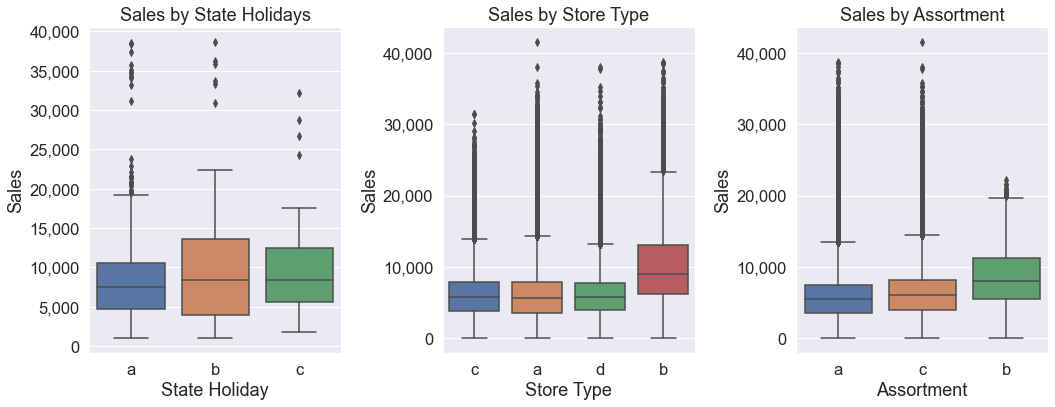

In [135]:
# checking sales by holidays, store type and assortment

aux1 = df1[(df1['state_holiday']!='0') & (df1['sales']>0)] # filtering sales that happened during a state holiday
plt.subplot(1,3,1)
h = sns.boxplot(x='state_holiday', y='sales', data=aux1)
h.set(xlabel="State Holiday", ylabel="Sales", title="Sales by State Holidays");
h.yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))


plt.subplot(1,3,2)
t = sns.boxplot(x='store_type', y='sales', data=df1)
t.set(xlabel="Store Type", ylabel="Sales", title="Sales by Store Type");
t.yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))


plt.subplot(1,3,3)
a = sns.boxplot(x='assortment', y='sales', data=df1)
a.set(xlabel="Assortment", ylabel="Sales", title="Sales by Assortment")
a.yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))


plt.tight_layout()

# FEATURE ENGINEERING

## Mind Map 

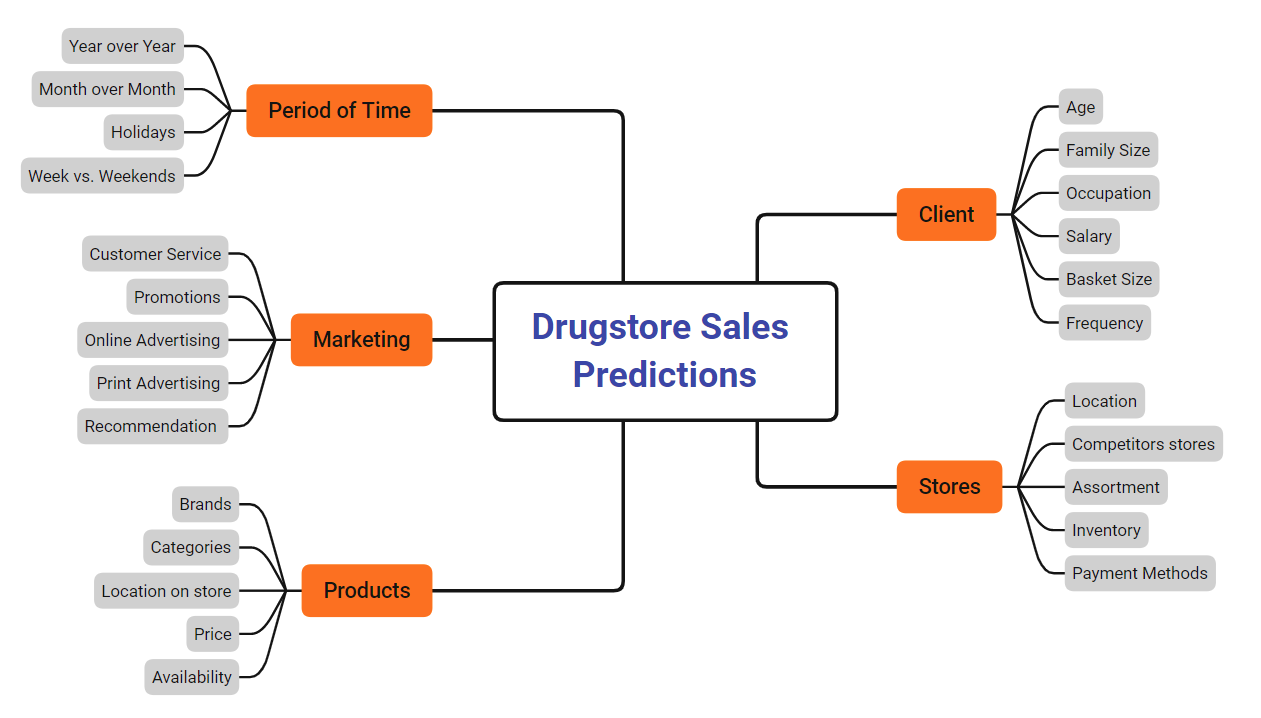

In [136]:
# importing hipothesis mind map
Image('../image/MindMapHypothesis.png')

## Creating Hypothesis

### Store Hypothesis 
1. Stores with bigger assortments should sell more.

2. Stores with closer competitors should sell less.

3. Stores with longer competitors should sell more. 

### Marketing Hypothesis
4. Stores with active promotions should sell more.
5. Stores with consecutive promotions should sell more.

### Periodicity Hypothesis
6. Stores sell more during the Christmas holiday than during other holidays.

6. Stores should sell more over the years.

9. Stores should sell more in the second semester.

10. Stores should sell more after the 10th of each month.

11. Stores should sell less on weekends.

12. Stores should sell more during the winter.

13. Stores should sell less during school holidays.

## Feature Engineering

In [137]:
df2 = df1.copy()
df2.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo2_interval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270,9,2008,0,38,1678,0
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570,11,2007,1,13,2010,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130,12,2006,1,14,2011,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620,9,2009,0,38,1678,0
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910,4,2015,0,38,1678,0


In [138]:
# creating 'year' from 'date'
df2['year'] = df2['date'].dt.year

# creating 'month' from 'date'
df2['month'] = df2['date'].dt.month

# creating 'day' from 'date'
df2['day'] = df2['date'].dt.day

# creating 'week_of_year' from 'date'
df2['week_of_year'] = df2['date'].dt.isocalendar().week.astype(np.int64)

# creating 'year_week' from 'date'
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# creating 'season' from 'date'
df2['season'] = df2['date'].map(season_from_date)

print(df2[['date','year','month','day','week_of_year','year_week', 'season']].dtypes)
df2[['date','year','month','day','week_of_year','year_week', 'season']].sample(5)

# === note:
# isocalender() - considers the first week of a year a thursday, and begins at 1.
# strftime() - considers the first week of a year with a monday, and begins at 0.

date            datetime64[ns]
year                     int64
month                    int64
day                      int64
week_of_year             int64
year_week               object
season                  object
dtype: object


,date,year,month,day,week_of_year,year_week,season
80830,2015-05-20,2015,5,20,21,2015-20,spring
502129,2014-04-07,2014,4,7,15,2014-14,spring
441658,2014-06-01,2014,6,1,22,2014-21,summer
77257,2015-05-23,2015,5,23,21,2015-20,spring
279407,2014-11-15,2014,11,15,46,2014-45,autumn


In [139]:
# changing 'sate_holiday' attribute by given classification
df2['state_holiday'] = df2['state_holiday'].apply (lambda x: 'Public holiday' if x=='a' 
                                                        else 'Easter holiday' if x=='b' 
                                                        else 'Christmas'      if x=='c'
                                                        else 'regular day')

print(df2[['state_holiday']].dtypes)

df2[['state_holiday']].head()

state_holiday    object
dtype: object


,state_holiday
0,regular day
1,regular day
2,regular day
3,regular day
4,regular day


In [140]:
# changing 'assortment' attribute by given classification
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x=='a' 
                                                 else 'extra' if x=='b' 
                                                 else 'extended')

print(df2[['assortment']].dtypes)

df2[['assortment']].head()

assortment    object
dtype: object


,assortment
0,basic
1,basic
2,basic
3,extended
4,basic


In [141]:
# creating 'competition_open_since' by combining 'competition_open_since_year' and 'competition_open_since_month'
df2['competition_open_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)

# creating 'competition_open_timeinmonths' by calculating the difference between 'date' and 'competition_open_since':
df2['competition_open_timeinmonths'] = ((pd.to_datetime(df2['date']).dt.date -  pd.to_datetime(df2['competition_open_since']).dt.date)/30).apply(lambda x: x.days).astype('int64')


print(df2[['date','competition_open_since_year','competition_open_since_month',
            'competition_open_since','competition_open_timeinmonths']].dtypes)

df2[['date','competition_open_since_year','competition_open_since_month',
     'competition_open_since','competition_open_timeinmonths']].sample(5)

# ==== note
# negative values for 'competition_open_timeinmonths' means that competitor openned after sales register

date                             datetime64[ns]
competition_open_since_year               int64
competition_open_since_month              int64
competition_open_since           datetime64[ns]
competition_open_timeinmonths             int64
dtype: object


,date,competition_open_since_year,competition_open_since_month,competition_open_since,competition_open_timeinmonths
353577,2014-08-28,1678,9,1678-09-01,4090
36624,2015-06-29,2011,3,2011-03-01,52
314737,2014-10-09,2014,4,2014-04-01,6
1014333,2013-01-03,2005,9,2005-09-01,89
966044,2013-02-15,2005,12,2005-12-01,87


In [142]:
# creating 'promo2_since' and 'promo2_since_timeinweeks'

# creating 'promo2_since' by combining 'promo2_since_year' and 'promo2_since_week'
df2['promo2_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str) # string type (year-week, ex: 2015-31)
df2['promo2_since'] = df2['promo2_since'].apply(lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta(days=7))  # date type (yyyy-mm-dd)

# creating 'promo_since_timeinweeks' by calculating the difference between 'date' and 'promo_since':
df2['promo2_since_timeinweeks'] = ((pd.to_datetime(df2['date']).dt.date - pd.to_datetime(df2['promo2_since']).dt.date)/7).apply( lambda x: x.days).astype(np.int64)

print(df2[['date', 'promo', 'promo2', 'promo2_since_week', 'promo2_since_year', 'promo2_since', 'promo2_since_timeinweeks']].dtypes)
df2[['date', 'promo', 'promo2', 'promo2_since_week', 'promo2_since_year', 'promo2_since', 'promo2_since_timeinweeks' ]].sample(5)

# ==== note
# negative values for 'promo2_since_timeinweeks' means that promotion happened after sales register

date                        datetime64[ns]
promo                                int64
promo2                               int64
promo2_since_week                    int64
promo2_since_year                    int64
promo2_since                datetime64[ns]
promo2_since_timeinweeks             int64
dtype: object


,date,promo,promo2,promo2_since_week,promo2_since_year,promo2_since,promo2_since_timeinweeks
983887,2013-01-30,0,1,1,2013,2012-12-31,4
499307,2014-04-10,0,1,36,2013,2013-09-02,31
530243,2014-03-13,0,0,38,1678,1678-09-12,17505
3819,2015-07-28,1,0,38,1678,1678-09-12,17577
479108,2014-04-28,1,0,38,1678,1678-09-12,17512


In [143]:
# creating 'is_promo2' to check if the purchase was during a promotion ('promo2')

month_map = { 1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
              7: 'Jul', 8: 'Ago', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

# # filling Na with "0"
# df2['promo2_interval'].fillna(0, inplace=True)

# finding the month name given month number by mapping the "month_map" dictionary
df2['month_map'] = df2['date'].dt.month.map(month_map)


df2['is_promo2'] = df2[['promo2_interval', 'month_map']].apply(lambda x: 0 if x['promo2_interval'] == 0
                                                                    else 1 if x['month_map'] in x['promo2_interval'].split(',')
                                                                    else 0, axis=1 )

print(df2[['promo2_interval','month_map','is_promo2']].dtypes)

df2[['date', 'promo','promo2','promo2_interval','month_map','is_promo2']].head()

promo2_interval    object
month_map          object
is_promo2           int64
dtype: object


,date,promo,promo2,promo2_interval,month_map,is_promo2
0,2015-07-31,1,0,0,Jul,0
1,2015-07-31,1,1,"Jan,Apr,Jul,Oct",Jul,1
2,2015-07-31,1,1,"Jan,Apr,Jul,Oct",Jul,1
3,2015-07-31,1,0,0,Jul,0
4,2015-07-31,1,0,0,Jul,0


In [1285]:
df2.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval', 'year', 'month', 'day',
       'week_of_year', 'year_week', 'season', 'competition_open_since',
       'competition_open_timeinmonths', 'promo2_since',
       'promo2_since_timeinweeks', 'month_map', 'is_promo2'],
      dtype='object')

In [144]:
# reordering columns 
df2 = df2[['store', 'date', 'day_of_week', 'sales','customers', 'open', 'state_holiday', 'school_holiday', 'store_type', 'assortment',
           'competition_distance', 'competition_open_since_month', 'competition_open_since_year', 'competition_open_since', 'competition_open_timeinmonths',
           'promo', 'promo2', 'promo2_since_week', 'promo2_since_year', 'promo2_interval',  'promo2_since', 'promo2_since_timeinweeks', 'month_map', 'is_promo2',
           'year', 'month', 'day', 'week_of_year', 'year_week', 'season']]

In [145]:
print(df2.dtypes)
df2.head(2)

store                                     int64
date                             datetime64[ns]
day_of_week                               int64
sales                                     int64
customers                                 int64
open                                      int64
state_holiday                            object
school_holiday                            int64
store_type                               object
assortment                               object
competition_distance                      int64
competition_open_since_month              int64
competition_open_since_year               int64
competition_open_since           datetime64[ns]
competition_open_timeinmonths             int64
promo                                     int64
promo2                                    int64
promo2_since_week                         int64
promo2_since_year                         int64
promo2_interval                          object
promo2_since                     datetim

,store,date,day_of_week,sales,customers,open,state_holiday,school_holiday,store_type,assortment,...,promo2_since,promo2_since_timeinweeks,month_map,is_promo2,year,month,day,week_of_year,year_week,season
0,1,2015-07-31,5,5263,555,1,regular day,1,c,basic,...,1678-09-12,17577,Jul,0,2015,7,31,31,2015-30,summer
1,2,2015-07-31,5,6064,625,1,regular day,1,a,basic,...,2010-03-22,279,Jul,1,2015,7,31,31,2015-30,summer


# VARIABLE FILTERING

In [146]:
df3=df2.copy()

## Lines Filtering

In [147]:
df3 = df3[(df3['open']!=0) & (df3['sales']>0)]

## Columns Selections

In [148]:
df3.columns

Index(['store', 'date', 'day_of_week', 'sales', 'customers', 'open',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'competition_open_since',
       'competition_open_timeinmonths', 'promo', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo2_interval', 'promo2_since',
       'promo2_since_timeinweeks', 'month_map', 'is_promo2', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'season'],
      dtype='object')

In [149]:
cols_drop = ['customers','open','promo2_interval','month_map']
df3 = df3.drop(cols_drop, axis=1)

# EDA

In [150]:
df4 = df3.copy()

print('Date min.:', df4['date'].min())
print('Date max.:', df4['date'].max())

df4 = df3[df3['date']<'2015-01-01'].copy() # filtering year for better comparative analysis
print('New date max.:', df4['date'].max())

Date min.: 2013-01-01 00:00:00
Date max.: 2015-07-31 00:00:00
New date max.: 2014-12-31 00:00:00


## Univariate Analysis

In [151]:
num_df4 = df4.select_dtypes(include=['int64','float64'])
cat_df4 = df4.select_dtypes(exclude=['int64','float64','datetime64[ns]'])

### Response Variable

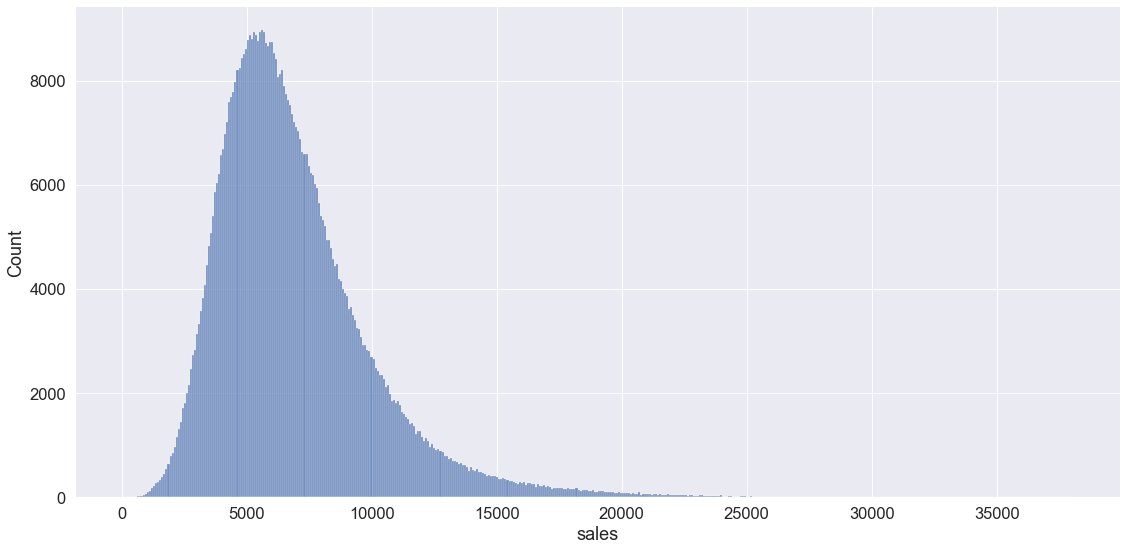

In [153]:
sns.displot(df4['sales'], legend=True, kde=False, height=8, aspect=2);

### Numerical Variables

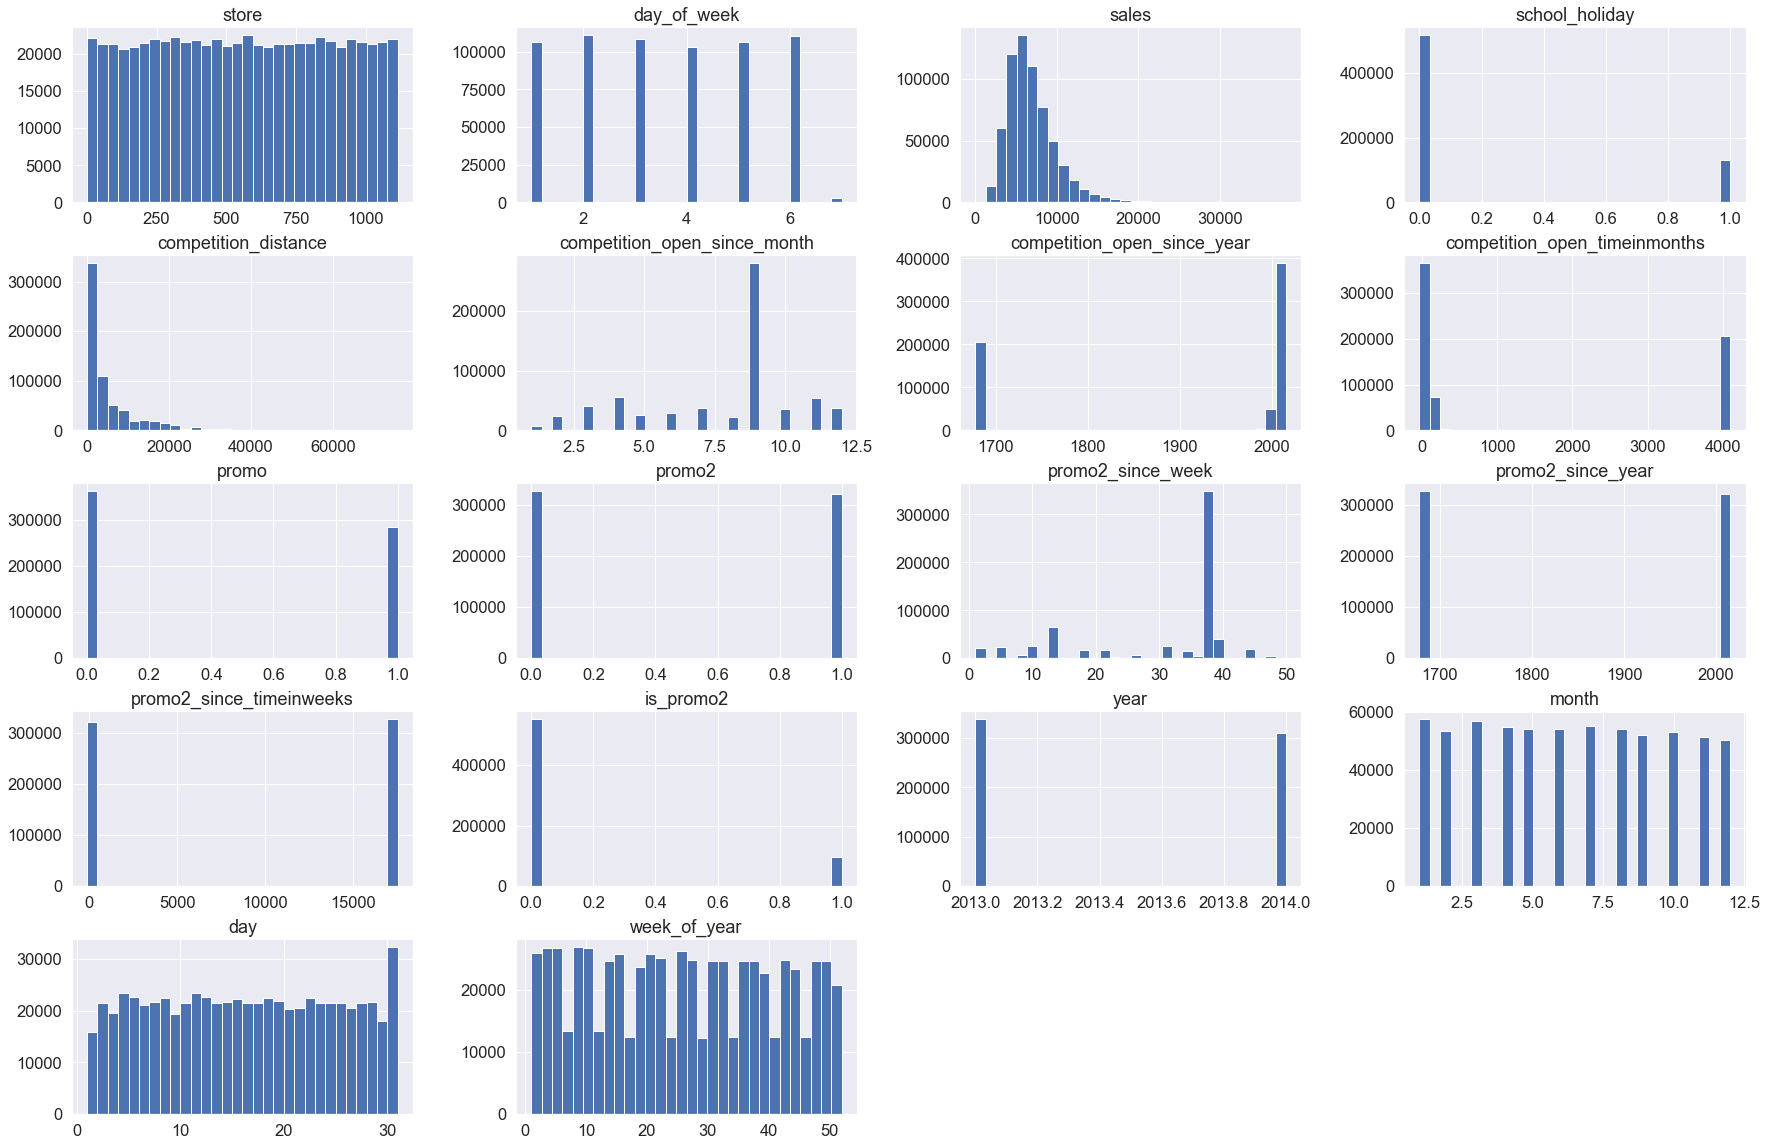

In [155]:
plt.rcParams['figure.figsize'] = [30, 20]
num_df4.hist(bins=30);
personal_settings()

### Categorical Variables

In [156]:
display(cat_df4.head())

print('\nstate_holiday:', cat_df4['state_holiday'].unique())
print('store_type:', cat_df4['store_type'].unique())
print('assortment:', cat_df4['assortment'].unique())

print('\nyear_week min:', cat_df4['year_week'].min())
print('year_week max:', cat_df4['year_week'].max())

,state_holiday,store_type,assortment,year_week,season
236380,regular day,c,basic,2014-52,winter
236381,regular day,a,basic,2014-52,winter
236382,regular day,a,basic,2014-52,winter
236383,regular day,c,extended,2014-52,winter
236384,regular day,a,basic,2014-52,winter



state_holiday: ['regular day' 'Christmas' 'Public holiday' 'Easter holiday']
store_type: ['c' 'a' 'd' 'b']
assortment: ['basic' 'extended' 'extra']

year_week min: 2013-00
year_week max: 2014-52


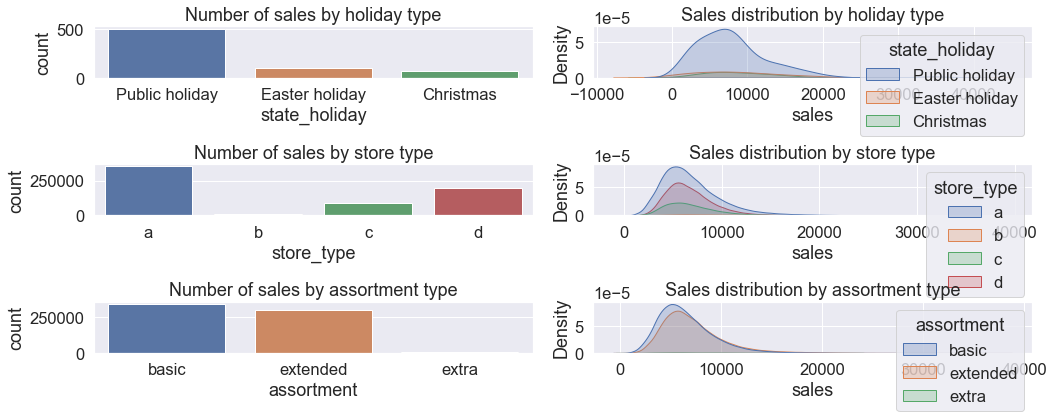

In [157]:
# sales by 'state_holiday'
a = df4[df4['state_holiday']!='regular day']
plt.subplot(3,2,1)
sns.countplot(data=a, x='state_holiday', order=['Public holiday', 'Easter holiday', 'Christmas']).set_title("Number of sales by holiday type")

plt.subplot(3,2,2)
sns.kdeplot(data=a, x='sales', hue='state_holiday', hue_order=['Public holiday', 'Easter holiday', 'Christmas'], fill=True).set_title("Sales distribution by holiday type");


# sales by 'store_type'
plt.subplot(3,2,3)
sns.countplot(data=df4, x='store_type', order=['a', 'b', 'c', 'd']).set_title("Number of sales by store type")

plt.subplot(3,2,4)
sns.kdeplot(data=df4, x="sales", hue="store_type", hue_order=['a', 'b', 'c', 'd'], fill=True).set_title("Sales distribution by store type")


# sales by 'assortment'
plt.subplot(3,2,5)
sns.countplot(data=df4, x='assortment', order=['basic', 'extended', 'extra']).set_title("Number of sales by assortment type");

plt.subplot(3,2,6)
sns.kdeplot(data=df4, x="sales", hue="assortment", hue_order=['basic', 'extended', 'extra'], fill=True).set_title("Sales distribution by assortment type");

plt.tight_layout()

## Bivariate Analysis

Hypothesis Resume

In [160]:
tab = [ ['Hypothesis', 'Conclusion', 'Relevance', 'Analysis'],
        ['H1 Stores with bigger assortments should sell more.','True', 'High',  'Stores with bigger assortments sell more on average.'],
        ['H2 Stores with closer competitors should sell less.','False','High', 'Distance from competitors does not seem to correlate with store sales.'],
        ['H3 Stores with longer competitors should sell more.','False','Low',  ' Period of opened competitor does not seem to correlate with store sales.'],
        ['H4 Stores with active promotions should sell more.','True','Low', 'Stores with active promotions sell 30% more on average.'],
        ['H5 Stores with consecutive promotions should sell more.','False','High', 'Stores with consecutive promotions sell 10% less on average.'],
        ['H6 Stores sell more during Christmas holiday than on other holidays.','True' ,'Low', 'Stores sell more during the Christmas holiday than during other holidays.'],
        ['H7 Stores should sell more over the years.','False','High', 'Sales decreased $-122,071,188.00 from 2013 to 2014, which represents -5.30%.'],
        ['H8 Stores should sell more in the second semester.','False', 'High', 'Stores sold more in the second semester in 2013, but not in 2014.'],
        ['H9 Stores should sell more after the 10th of each month.','False','High', 'Sales difference B&A 10th of each month is $504.77, which represents 7.45%.'],
        ['H10 Stores should sell less on weekends.','True','Low', 'The daily avg sales is around -$180 less on weekends, which represents -2,5%.'],
        ['H11 Stores should sell more during the winter.','True','High', 'Sales during the winter correspond to 29.44% of total.'],
        ['H12 Stores should sell less during school holidays.','False','High', 'Stores sell $200.74 more during school holidays, which represents 2.92%.'],
        
      ]

print(tabulate(tab, headers = 'firstrow'))

Hypothesis                                                            Conclusion    Relevance    Analysis
--------------------------------------------------------------------  ------------  -----------  -----------------------------------------------------------------------------
H1 Stores with bigger assortments should sell more.                   True          High         Stores with bigger assortments sell more on average.
H2 Stores with closer competitors should sell less.                   False         High         Distance from competitors does not seem to correlate with store sales.
H3 Stores with longer competitors should sell more.                   False         Low          Period of opened competitor does not seem to correlate with store sales.
H4 Stores with active promotions should sell more.                    True          Low          Stores with active promotions sell 30% more on average.
H5 Stores with consecutive promotions should sell more.               False   

### Stores with bigger assortments should sell more.
**True:** Stores with bigger assortments sell more on average.

,assortment,qty_stores,avg_sales
0,basic,593,6612.76
1,extended,513,7229.01
2,extra,9,8364.17


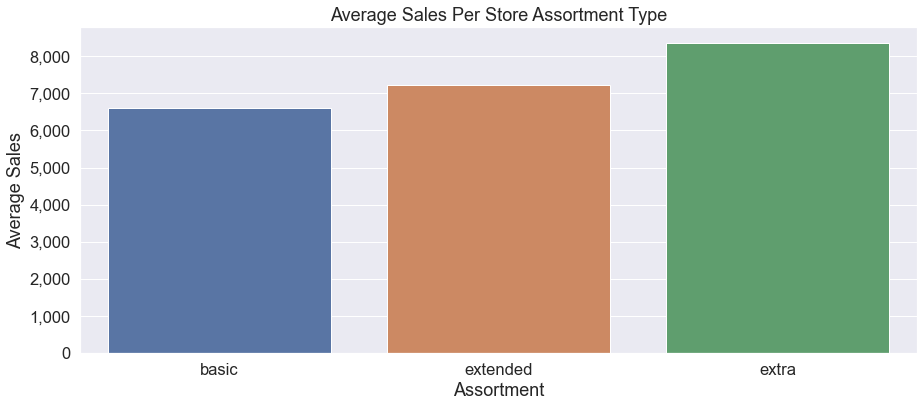

In [1300]:
# checking 'sales' by 'assortoment'
aux = df4[['store','assortment', 'sales']].copy()

aux2 = (aux.groupby('assortment').agg(qty_stores = ('store', 'nunique'),
                                   avg_sales  = ('sales', 'mean'))).reset_index()

aux3 = pd.pivot_table(aux2, columns='assortment')
display(aux2)

a = sns.barplot(data=aux2, x='assortment', y='avg_sales');
a.set(xlabel="Assortment", ylabel="Average Sales", title="Average Sales Per Store Assortment Type");
a.yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))

### Stores with closer competitors should sell less.
**False:** Distance from competitors does not seem to correlate with store sales.

In [1351]:
# creating bins for 'competition_distance'
aux1 = df4[df4['competition_distance']!=0][['competition_distance','sales','store']].copy()
aux1.head()

bingroup = list(np.arange(0,85000,5000)) # The maximum distance is: 75860.0
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins = bingroup)
display(aux1.head())

,competition_distance,sales,store,competition_distance_binned
236380,1270,2605,1,"(0, 5000]"
236381,570,2269,2,"(0, 5000]"
236382,14130,3804,3,"(10000, 15000]"
236383,620,10152,4,"(0, 5000]"
236384,29910,1830,5,"(25000, 30000]"


In [1352]:
# regrouping data using the bins
aux2 = ( aux1.groupby('competition_distance_binned').agg(qty_stores = ('store', 'nunique'),
                                                         avg_sales  = ('sales', 'mean'),
                                                         sum_sales  = ('sales', 'sum' )  ) ).reset_index()


display(aux2.head())

,competition_distance_binned,qty_stores,avg_sales,sum_sales
0,"(0, 5000]",763,7006.81,3107515082
1,"(5000, 10000]",162,6663.07,623523277
2,"(10000, 15000]",65,6547.03,245801568
3,"(15000, 20000]",65,6813.10,256404262
4,"(20000, 25000]",25,8004.07,117131629


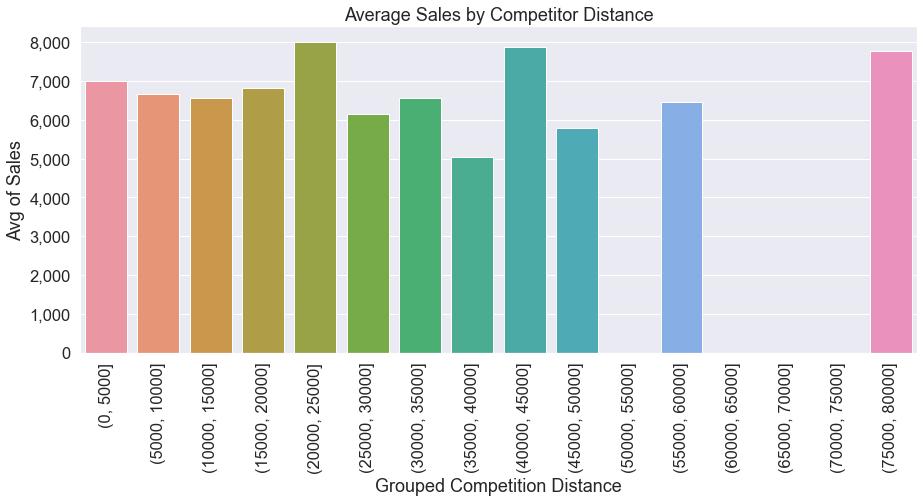

In [1353]:
a = sns.barplot(data=aux2, x='competition_distance_binned', y='avg_sales')
a.set(xlabel='Grouped Competition Distance', ylabel='Avg of Sales', title='Average Sales by Competitor Distance')
a.yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'));
plt.xticks(rotation=90);

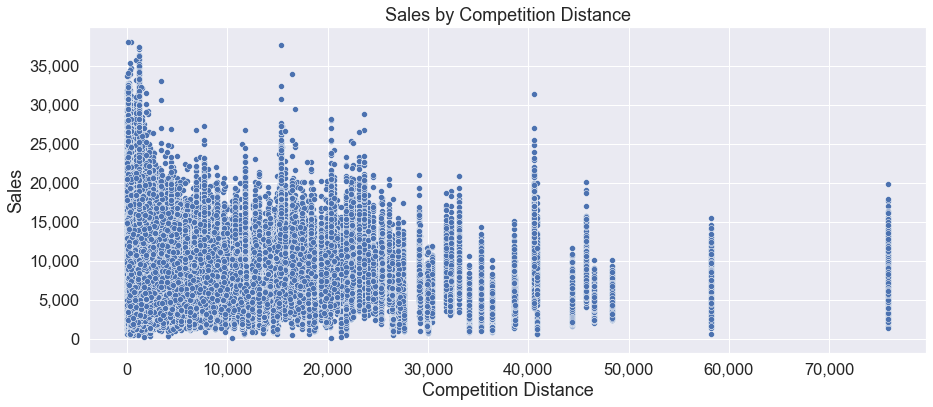

In [1354]:
a = sns.scatterplot(data=aux1, x='competition_distance', y='sales')
a.set(xlabel='Competition Distance', ylabel='Sales', title='Sales by Competition Distance')
a.yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'));
a.xaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'));

### Stores with longer competitors should sell more.
**False:** Period of opened competitor does not seem to correlate with store sales.

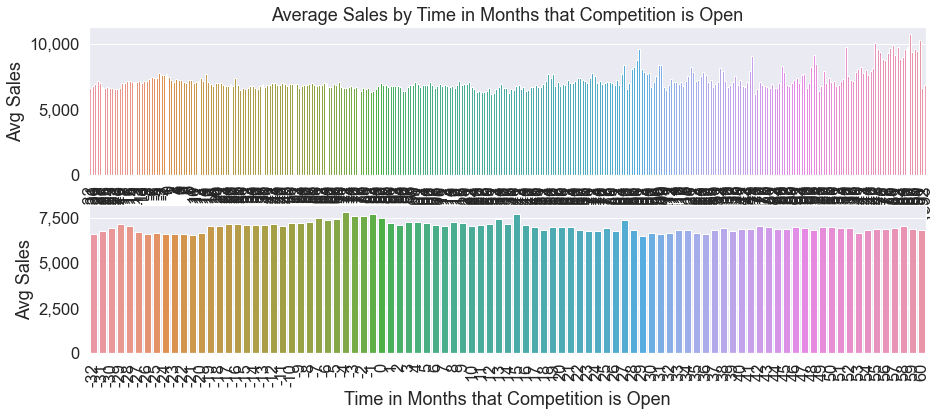

In [1305]:
# checking 'sales' by 'competition_open_timeinmonths' // filtering filled data
aux1 = df4[df4['competition_open_since_year']!=min_year][['store', 'sales', 'competition_open_timeinmonths']].copy()
#display(aux1.head())

aux2 = ( aux1.groupby('competition_open_timeinmonths').agg(qty_stores = ('store', 'nunique'),
                                                           avg_sales  = ('sales', 'mean'),
                                                           sum_sales  = ('sales', 'sum' )  ) ).reset_index()
#display(aux2.head())


plt.subplot(2,1,1)
a = sns.barplot(data = aux2, x='competition_open_timeinmonths', y='avg_sales')
a.set(xlabel='Time in Months that Competition is Open', ylabel='Avg Sales', title='Average Sales by Time in Months that Competition is Open');
a.yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'));
plt.xticks(rotation=90);

plt.subplot(2,1,2)
b = sns.barplot(data = aux2[aux2['competition_open_timeinmonths']<=60], x='competition_open_timeinmonths', y='avg_sales')
b.set(xlabel='Time in Months that Competition is Open', ylabel='Avg Sales');
b.yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'));
plt.xticks(rotation=90);

# ==== note
# negative values for 'competition_open_timeinmonths' means that competitor openned after sales register

### Stores with active promotions should sell more.
**True:** Stores with active promotions sell 30% more on average.

,active_promo,qty_stores,avg_sales
0,active promo,1115,7768.83
1,no promo,1115,5977.99


Stores with active promotions sell 29.96% more than stores with no promotions


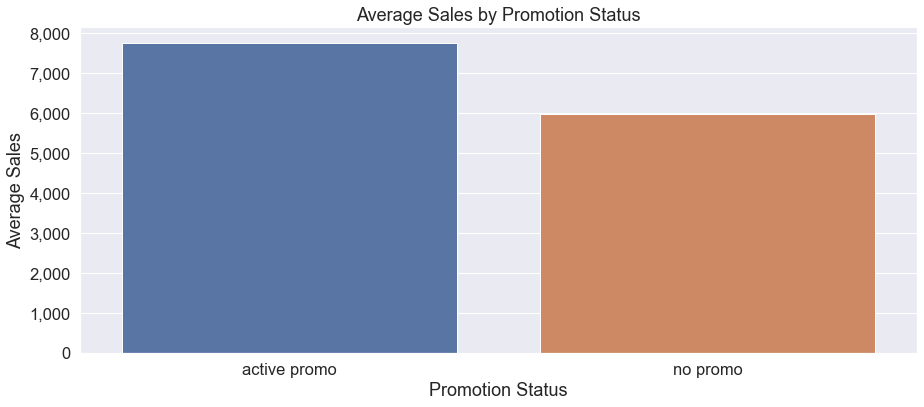

In [1306]:
# promo - indicates whether a store is running a promo on that day
# is_promo2 - indicates wehter a store is during a promo2 interval

aux = df4[['store', 'sales', 'promo', 'is_promo2']].copy()
aux['active_promo'] = aux[['promo', 'is_promo2']].apply(lambda x: 'no promo' if ((x['promo']==0) & (x['is_promo2']==0)) else 'active promo' , axis=1)
aux.head()

aux2 = ( aux.groupby('active_promo').agg ( qty_stores = ('store', 'nunique'), avg_sales  = ('sales', 'mean')) ).reset_index()
display(aux2.head())

sales_promo = aux2.loc[aux2['active_promo']=='active promo']['avg_sales'][0]
sales_nopromo = aux2.loc[aux2['active_promo']=='no promo']['avg_sales'][1]
percentage = ((sales_promo - sales_nopromo)/sales_nopromo)
print('Stores with active promotions sell {:.2%}'.format(percentage), 'more than stores with no promotions')

a = sns.barplot(data=aux2, x='active_promo', y='avg_sales');
a.set(xlabel="Promotion Status", ylabel="Average Sales", title="Average Sales by Promotion Status");
a.yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))

### Stores with consecutive promotions should sell more.
**False:** Stores with consecutive promotions sell 10% less on average.

,promo2,qty_stores,avg_sales
0,0,544,8601.64
1,1,571,7805.53


Stores with only first promotion sell 10.20% more than stores with consecutive promotions


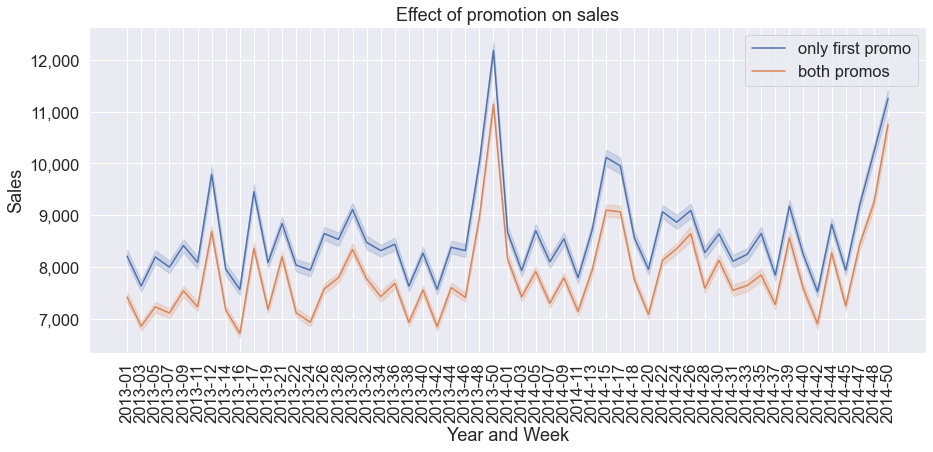

In [1307]:
# promo - indicates whether a store is running a promo on that day
# promo2 - is a continuing and consecutive promotion for some stores

aux = df4[df4['promo']==1][['date','store', 'sales', 'promo', 'promo2', 'year_week']].sort_values('year_week', ascending=True).copy()

aux1 = ( aux.groupby('promo2').agg ( qty_stores = ('store', 'nunique'), avg_sales  = ('sales', 'mean')) ).reset_index()
display(aux1.head())

only_first_promo = aux1.loc[aux1['promo2']==0]['avg_sales'][0]
both_promos = aux1.loc[aux1['promo2']==1]['avg_sales'][1]
percentage = ((only_first_promo - both_promos)/both_promos)
print('Stores with only first promotion sell {:.2%}'.format(percentage), 'more than stores with consecutive promotions')

a = sns.lineplot(data = aux, x='year_week', y='sales', hue='promo2')
a.legend(['only first promo', 'both promos']);
a.set(xlabel="Year and Week", ylabel="Sales", title="Effect of promotion on sales");
a.yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))
plt.xticks(rotation=90);

###  Stores sell more during the Christmas holiday than during other holidays.
**True:** Stores sell more during the Christmas holiday than during other holidays.

,state_holiday,sales
0,Christmas,9743.75
1,Easter holiday,9566.15
2,Public holiday,8257.53


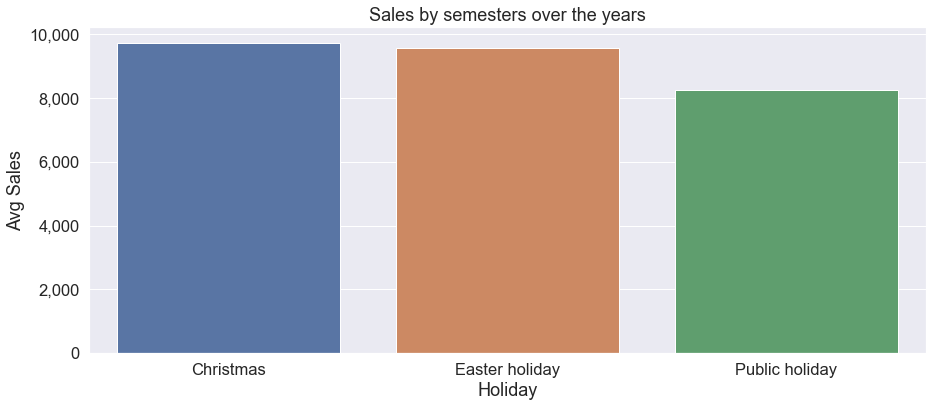

In [1308]:
# checking 'sales' by 'state_holiday'
aux = df4[df4['state_holiday'] != 'regular day']
aux1 = aux[['state_holiday','sales']].groupby('state_holiday').mean().reset_index()

a = sns.barplot(data = aux1, x = 'state_holiday', y = 'sales');
a.set(xlabel="Holiday", ylabel="Avg Sales", title="Sales by semesters over the years");
a.yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))

display(aux1)

### Stores should sell more over the years.
**False:** Sales decreased -$122,071,188.00 from 2013 to 2014, which represents -5.30%.

,year,sales
0,2013,2302876084
1,2014,2180804896


Sales decreased $-122,071,188.00 from 2013 to 2014, which represents -5.30%.


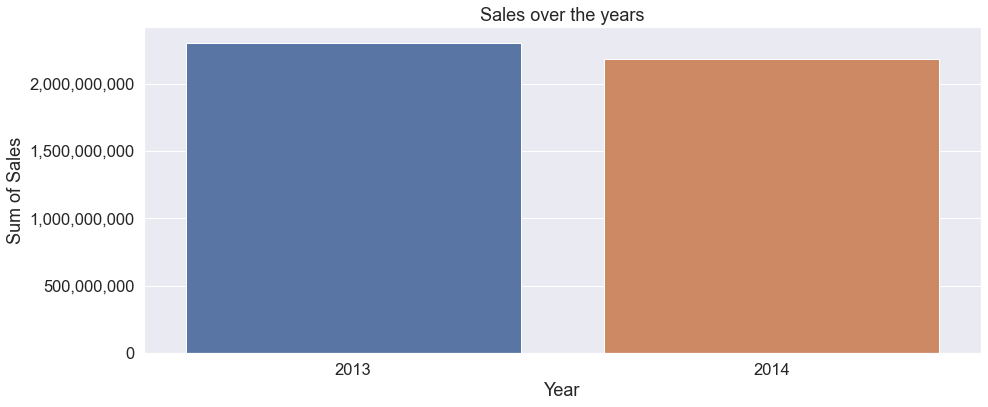

In [1309]:
aux1 = df4[['year','sales']].groupby('year').sum().reset_index()
display(aux1)

sales_2013 = aux1.loc[aux1['year']==2013]['sales'][0]
sales_2014 = aux1.loc[aux1['year']==2014]['sales'][1]
percentage = ((sales_2014 - sales_2013)/sales_2013)
print('Sales decreased ${:,.2f}'.format(sales_2014 - sales_2013), 'from 2013 to 2014, which represents {:,.2%}.'.format(percentage))

a = sns.barplot(data=aux1, x='year', y='sales');
a.set(xlabel="Year", ylabel="Sum of Sales", title="Sales over the years");
a.yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))

### Stores should sell more in the second semester.
**False:** Inconclusive. Stores sold more in the seconde semester in 2013, but not in 2014.

year       sales            
semester                 1           2
0         2013  1102391697  1200484387
1         2014  1138982603  1041822293

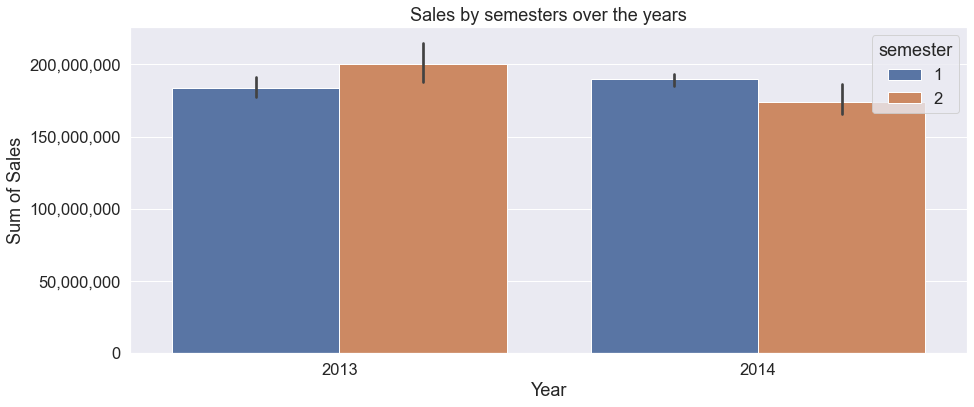

In [1310]:
aux1 = df4[['month','sales','year']].groupby(['year','month']).sum().reset_index() 
aux1['semester'] = aux1.apply(lambda x: 1 if x['month']<=6 else 2, axis=1)
#display(aux1)

aux2 = aux1[['year', 'semester','sales']].groupby(['semester','year']).sum().reset_index() #display(aux2)
aux3 = pd.pivot_table(aux2, columns='semester', index='year')
display(aux3.reset_index()) 

a = sns.barplot(data = aux1, x='year', y='sales', hue='semester')
a.set(xlabel="Year", ylabel="Sum of Sales", title="Sales by semesters over the years");
a.yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))

### Stores should sell more after the 10th of each month.
**False:** The daily average sales difference between before and after 10th of each month is $504.77, which represents 7.45%.

,before_after10,sales
1,before_day10,7276.14
0,after_day10,6771.38


The daily average sales difference between before and after 10th of each month is $504.77, which represents 7.45%.


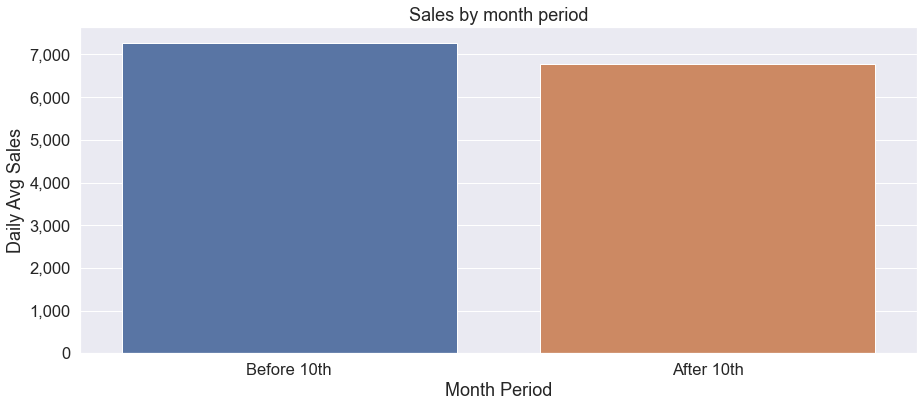

In [1311]:
aux1 = df4[['day','sales']].groupby('day').mean().reset_index()
aux1['before_after10'] = aux1['day'].apply (lambda x: 'before_day10' if x <= 10 else 'after_day10')
#display(aux1)

aux2 = aux1[['before_after10','sales']].groupby('before_after10').mean().reset_index()
display(aux2.sort_values('before_after10', ascending=False))

before_day10 = aux2.loc[aux2['before_after10']=='before_day10']['sales'][1]
after_day10 = aux2.loc[aux2['before_after10']=='after_day10']['sales'][0]
percentage = ((before_day10 - after_day10)/after_day10)
print('The daily average sales difference between before and after 10th of each month is ${:,.2f},'.format(before_day10 - after_day10), 'which represents {:.2%}.'.format(percentage))

a = sns.barplot(data=aux2, x='before_after10', y='sales', order=['before_day10', 'after_day10']);
a.set(xlabel="Month Period", ylabel="Daily Avg Sales", title="Sales by month period");
a.set(xticklabels=['Before 10th', 'After 10th'])
a.yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))

### Stores should sell less on weekends.
**True:** The daily average sales is around -$180 less on weekends, which represents -2,5%.

,weekdays,avg_sales
0,weekday,7135.22
1,weekend,6956.11


The sales difference between weekdays and weekends is $-179.10, which represents -2.51%.


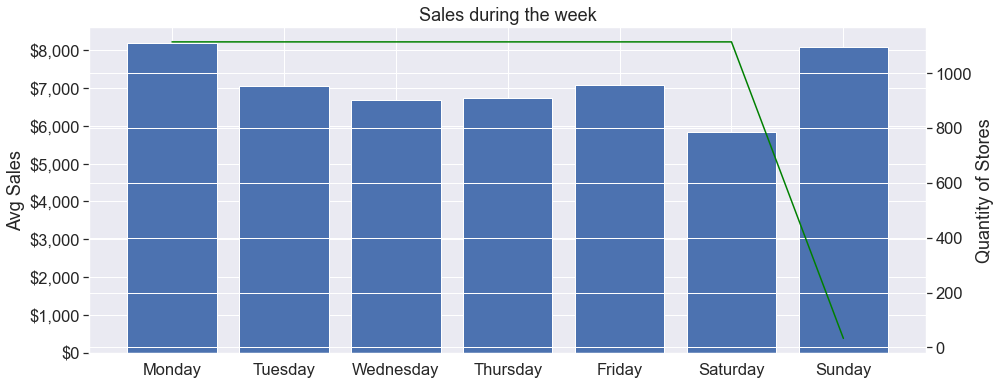

,day_of_week,qty_stores,avg_sales,weekdays
0,1,1115,8188.96,weekday
1,2,1115,7034.51,weekday
2,3,1115,6666.58,weekday
3,4,1115,6724.69,weekday
4,5,1115,7061.34,weekday
5,6,1115,5827.30,weekend
6,7,33,8084.93,weekend


In [1312]:
aux1 = df4[['day_of_week', 'sales', 'store']].copy()
aux1['weekdays'] = aux1.apply(lambda x: 'weekday' if x['day_of_week']<6 else 'weekend', axis=1)
#display(aux1.head())

aux2 = ( aux1.groupby('day_of_week').agg( qty_stores = ('store', 'nunique'), avg_sales  = ('sales', 'mean'), weekdays = ('weekdays', lambda x: x.unique()) ) ).reset_index()
#display(aux2)

aux3 = aux2[['weekdays', 'avg_sales']].groupby('weekdays').mean().reset_index()
display(aux3)

avg_weekday = aux3[aux3['weekdays']=='weekday']['avg_sales'][0]
avg_weekend = aux3[aux3['weekdays']=='weekend']['avg_sales'][1]
percentage = ((avg_weekend - avg_weekday)/avg_weekday)

print('The sales difference between weekdays and weekends is ${:,.2f},'.format(avg_weekend - avg_weekday), 'which represents {:.2%}.'.format(percentage))

# ===

fig = plt.figure() # creating matplotlib figure
ax = fig.add_subplot() # creating matplotlib axes
ax2 = ax.twinx() # creating another axes that shares the same x-axis as ax.

ax.bar(aux2['day_of_week'], height=aux2['avg_sales']);
ax2.plot(aux2['day_of_week'], aux2['qty_stores'], color='green');

plt.title('Sales during the week')
ax.yaxis.set_major_formatter(mticker.StrMethodFormatter('${x:,.0f}'))
plt.xticks(ticks = aux2['day_of_week'], labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
ax.set_ylabel('Avg Sales')
ax2.set_ylabel('Quantity of Stores')
#ax2.grid(visible=False)

plt.show();

display(aux2)

### Stores should sell more during the winter.
**True:** Sales during the winter correspond to 29.44% of total.

In [1317]:
aux1 = df4[['store', 'sales', 'season']]
aux1.head()

aux2 = ( aux1.groupby('season').agg( qty_stores = ('store', 'nunique'),
                                     avg_sales = ('sales', 'mean')     ) ).reset_index()

aux2['season_share_%']=aux2['avg_sales']/aux2['avg_sales'].sum()*100
winter_share=aux2[aux2['season']=='winter']['season_share_%'][3]

display(aux2)
print('Sales during the winter correspond to {:,.2f}% of total.'.format(winter_share))

,season,qty_stores,avg_sales,season_share_%
0,autumn,1115,6890.47,23.84
1,spring,1115,6758.33,23.39
2,summer,1115,6740.93,23.33
3,winter,1115,8507.94,29.44


Sales during the winter correspond to 29.44% of total.


### Stores should sell less during school holidays.
**False:** Stores sell $200.74 more during school holidays, which represents 2.92%.

In [1343]:
aux1 = ( df4[['state_holiday', 'school_holiday','sales']].groupby(['school_holiday']).agg( avg_sales = ('sales', 'mean'),
                                                                                           count_sales = ('sales', 'count') ) ).reset_index()
display(aux1)

sales_sch_holiday = aux1[aux1['school_holiday']==1]['avg_sales'][1]
sales_nosch_holiday = aux1[aux1['school_holiday']==0]['avg_sales'][0]
percentage = ((sales_sch_holiday - sales_nosch_holiday)/sales_nosch_holiday)

print('Stores sell ${:,.2f} more during school holidays,'.format( sales_sch_holiday - sales_nosch_holiday ), 'which represents {:.2%}.'.format(percentage))

,school_holiday,avg_sales,count_sales
0,0,6875.13,516446
1,1,7075.88,131863


Stores sell $200.74 more during school holidays, which represents 2.92%.


## Multivariate Analysis

### Numerical Attributes

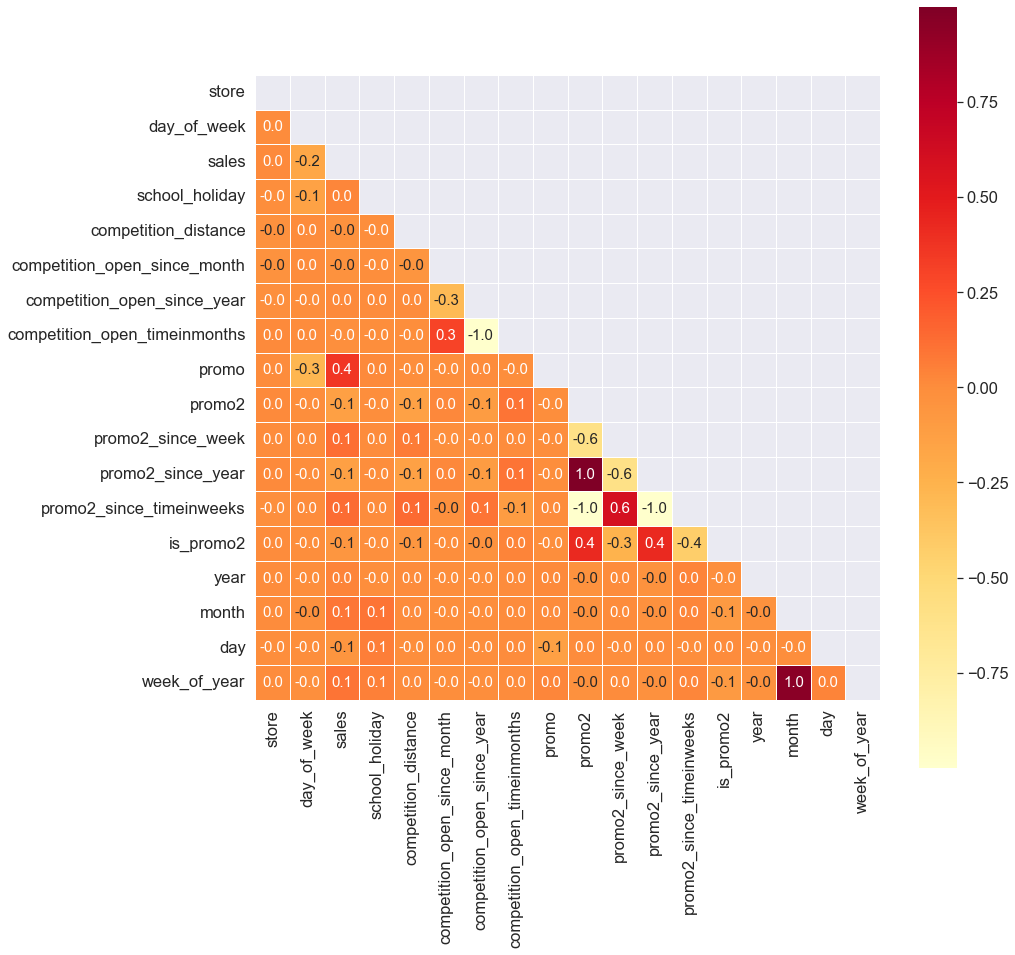

In [166]:
correlation = num_df4.corr(method = 'pearson')

corr_mask = np.triu(correlation)

plt.figure(figsize=(14,14))
sns.heatmap(correlation, 
            cmap='YlOrRd', 
            annot=True, 
            annot_kws={'fontsize':'small'},
            fmt='.1f',
            linewidths=0.8, 
            square=True,
            mask=corr_mask);

### Categorical Attributes

In [179]:
cat_df4.columns

Index(['state_holiday', 'store_type', 'assortment', 'year_week', 'season'], dtype='object')

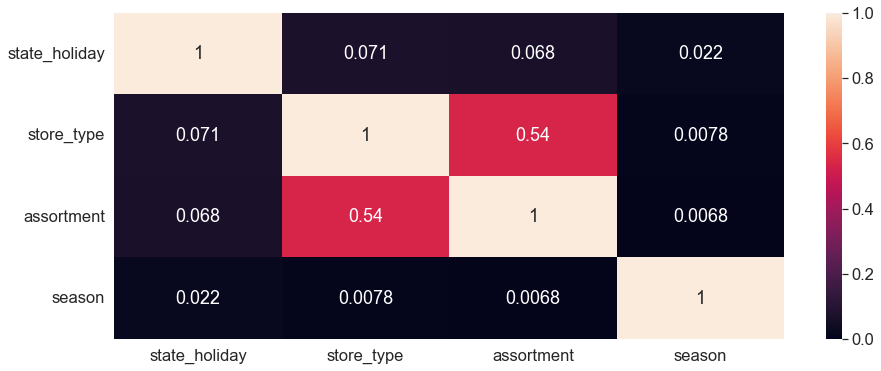

In [185]:
# calculating Cramér's V (formula at Helper Function section)

a1 = cramer_v(cat_df4['state_holiday'], cat_df4['state_holiday'])
a2 = cramer_v(cat_df4['state_holiday'], cat_df4['store_type'])
a3 = cramer_v(cat_df4['state_holiday'], cat_df4['assortment'])
a4 = cramer_v(cat_df4['state_holiday'], cat_df4['season'])

a5 = cramer_v(cat_df4['store_type'], cat_df4['state_holiday'])
a6 = cramer_v(cat_df4['store_type'], cat_df4['store_type'])
a7 = cramer_v(cat_df4['store_type'], cat_df4['assortment'])
a8 = cramer_v(cat_df4['store_type'], cat_df4['season'])

a9 = cramer_v(cat_df4['assortment'], cat_df4['state_holiday'])
a10 = cramer_v(cat_df4['assortment'], cat_df4['store_type'])
a11 = cramer_v(cat_df4['assortment'], cat_df4['assortment'])
a12 = cramer_v(cat_df4['assortment'], cat_df4['season'])

a13 = cramer_v(cat_df4['season'], cat_df4['state_holiday'])
a14 = cramer_v(cat_df4['season'], cat_df4['store_type'])
a15 = cramer_v(cat_df4['season'], cat_df4['assortment'])
a16 = cramer_v(cat_df4['season'], cat_df4['season'])


# final dataset 
t = pd.DataFrame({ 'state_holiday': [ a1,  a2,  a3,  a4],
                   'store_type':    [ a5,  a6,  a7,  a8],
                   'assortment':    [ a9, a10, a11, a12],
                   'season':        [a13, a14, a15, a16]  })

t = t.set_index(t.columns)
#display(t)

sns.heatmap(data=t, annot=True, vmin=0, vmax=1);